In [1]:
import pandas as pd

import os
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.io as isoio
import isolearn.keras as iso

import scipy.optimize as spopt
from scipy.stats import pearsonr

from logistic_regression_helpers import *


Using TensorFlow backend.


<h2>Load 5' Alternative Splicing Data</h2>

- Load a Pandas DataFrame + Matlab Matrix of measured Splicing Sequences<br/>
- isolearn.io loads all .csv and .mat files of a directory into memory as a dictionary<br/>
- The DataFrame has one column - padded_sequence - containing the splice donor sequence<br/>
- The Matrix contains RNA-Seq counts of measured splicing at each position across the sequence<br/>


In [2]:
#Load Splicing Data

splicing_dict = isoio.load('data/processed_data/splicing_5ss_data/splicing_5ss_data')


In [3]:
#This is how the Sequence dataframe looks

#Each sequence is 342 nt long.
splicing_dict['df'].head()

,padded_sequence
0,ACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCA...
1,ACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCA...
2,ACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCA...
3,ACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCA...
4,ACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCA...


In [4]:
#This is the shape of the corresponding splice donor RNA-Seq count matrix.

print(splicing_dict['hek_count'].shape)

(264647, 342)


<h2>A look at the Count Matrix</h2>

- Each row denotes a particular Splice donor sequence<br/>
- Each column denotes splicing at a particular position within the sequence<br/>
- As can be seen from the plot below, splicing typically happens at 3 different splice donors<br/>
- However, part of each sequence is randomly mutated, and splicing can occur between SD1 and SD2<br/>


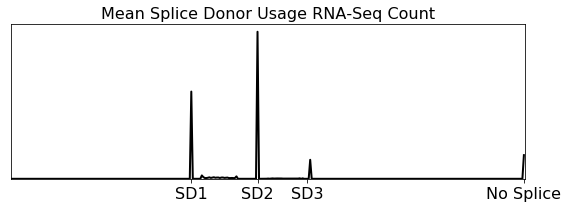

In [5]:
#There are three canonical splice donors, at position 120, 164 and 197
#Additionally, there is usage of donors inserted ranomly between position 120 and 164

f = plt.figure(figsize=(8, 3))

plt.plot(np.arange(342), np.ravel(splicing_dict['hek_count'].mean(axis=0)), linewidth=2, color='black')

plt.yticks([], [])
plt.xticks([120, 164, 197, 341], ['SD1', 'SD2', 'SD3', 'No Splice'], fontsize=16)
plt.xlim(0, 342)
plt.ylim(0)
plt.title('Mean Splice Donor Usage RNA-Seq Count', fontsize=16)

plt.tight_layout()
plt.show()


<h2>Create a Training and Test Set</h2>

- We create an index containing row numbers corresponding to training and test sequences<br/>
- Notice that we do not alter the underlying DataFrame, we only make lists of pointers to rows<br/>


In [6]:
#Generate training and test set indexes

test_set_size = 0.10

data_index = np.arange(len(splicing_dict['df']), dtype=np.int)

train_index = data_index[:-int(len(data_index) * test_set_size)]
test_index = data_index[train_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))

Training set size = 238183
Test set size = 26464


<h2>Create Data Generators</h2>

- In Isolearn, we always build data generators that will encode and feed us the data on the fly<br/>
- Here, for example, we create a training and test generator separately (using list comprehension)<br/>
- First argument: The list of row indices (of data points) for this generator<br/>
- Second argument: Dictionary or data sources<br/>
- Third argument: Batch size for the data generator
- Fourth argument: List of inputs, where each input is specified as a dictionary of attributes<br/>
- Fifth argument: List of outputs<br/>

In this example, we specify an NMerEncoder of nmer length 6 (hexamers) as the input encoder for the splice donor sequence.<br/>
We also specify the target output as the normalized RNA-Seq count at position 120 in the count matrix.

In [7]:
#Create a hexamer count data generator, to be used for logistic regression of SD1 Usage (HEK cell line)
#Set the batch sizes equal to the size of the train/test sets.

splicing_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : splicing_dict['df'],
            'hek_count' : splicing_dict['hek_count']
        },
        batch_size=len(idx),
        inputs = [
            {
                'id' : 'random_region_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['padded_sequence'][122: 122 + 35],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            }
        ],
        outputs = [
            {
                'id' : 'sd1_usage',
                'source_type' : 'matrix',
                'source' : 'hek_count',
                'extractor' : lambda c, index: np.ravel(c),
                'transformer' : lambda t: t[120] / np.sum(t)
            }
        ],
        randomizers = [],
        shuffle = False,
        densify_batch_matrices=True
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('test', test_index)]
}


In [15]:
#Timing for generating >10,000 4,096-dimensional input feature vectors of hexamer counts
#Note that this is for a single core: DataGenerators are multithread-safe

%timeit splicing_gens['all'][0]

[X], [y] = splicing_gens['all'][0]

print('')
print('X.shape = ' + str(X.shape))
print('y.shape = ' + str(y.shape))


3.1 s ± 280 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

X.shape = (10000, 4096)
y.shape = (10000,)


<h2>Execute the data generators by indexing them</h2>

In this example, we specified the batch size to be the entire train/test sets.<br/>
Hence, indexing into the generators at index 0 gives us the entire encoded dataset.


In [8]:
#Get training data from generator
[X_train], [y_train] = splicing_gens['train'][0]

#Get test data from generator
[X_test], [y_test] = splicing_gens['test'][0]
 

<h2>Perform Logistic Hexamer Regression</h2>

Here we take our X and y matrices and feed them into an optimization algorithm (LM-BFGS with Logistic Regression) in order to learn log odds ratio weights of each of the hexamer counts encoded in matrix X, on the basis of how they influence splice donor usage (y).


Starting logistic n-mer regression..
Regression finished.
Test set R^2 = 0.76, p = 0.0


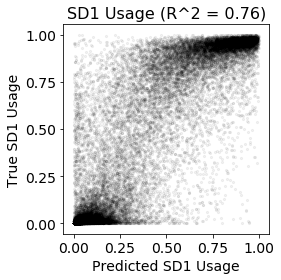

In [9]:
print("Starting logistic n-mer regression..")

w_init = np.zeros(X_train.shape[1] + 1)
lambda_penalty = 0

(w_bundle, _, _) = spopt.fmin_l_bfgs_b(log_loss, w_init, fprime=log_loss_gradient, args=(X_train, y_train, lambda_penalty), maxiter = 200)

print("Regression finished.")

#Collect weights
w = w_bundle[1:]
w_0 = w_bundle[0]

#Evaluate predictions on test set
y_test_pred = get_y_pred(X_test, w, w_0)

r_val, p_val = pearsonr(y_test_pred, y_test)
print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

#Plot test set scatter
f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_pred, y_test, color='black', s=5, alpha=0.05)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel('Predicted SD1 Usage', fontsize=14)
plt.ylabel('True SD1 Usage', fontsize=14)
plt.title("SD1 Usage (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)

plt.tight_layout()
plt.show()


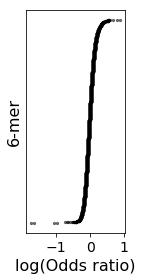

In [10]:
#Plot the sorted weights, from smallest to largest

sort_index = np.argsort(w)

f = plt.figure(figsize = (2, 4))

plt.scatter(w[sort_index], np.arange(w.shape[0]), s=5, c='black', alpha=0.5)

plt.xticks(fontsize=14)
plt.yticks([], [])

plt.xlabel('log(Odds ratio)', fontsize=16)
plt.ylabel('6-mer', fontsize=16)

plt.tight_layout()
plt.show()


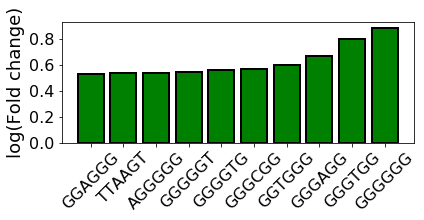

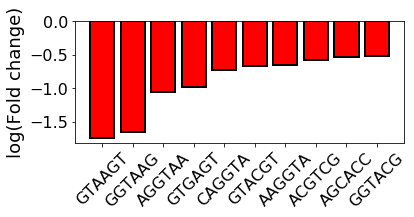

In [11]:
#Plot the 10 6-mers and corresponding weights of largest/smallest magnitude

#Make a vector of all hexamers
nmer_dict = splicing_gens['all'].encoders['random_region_1'].encoder.decode_map
nmers = np.array([nmer_dict[i] for i in range(len(nmer_dict))], dtype=np.object)

#Showcase 10 most enhancive motifs

f = plt.figure(figsize=(6, 3))

plt.bar(np.arange(10), w[sort_index][-10:], color='green', edgecolor='black', linewidth=2)
plt.xticks(np.arange(10), nmers[sort_index][-10:], rotation=45, fontsize=16)
plt.yticks(fontsize=16)

plt.ylabel('log(Fold change)', fontsize=18)

plt.tight_layout()
plt.show()

#Showcase 10 most repressive motifs

f = plt.figure(figsize=(6, 3))

plt.bar(np.arange(10), w[sort_index][:10], color='red', edgecolor='black', linewidth=2)
plt.xticks(np.arange(10), nmers[sort_index][:10], rotation=45, fontsize=16)
plt.yticks(fontsize=16)

plt.ylabel('log(Fold change)', fontsize=18)

plt.tight_layout()
plt.show()
